# Solar Radiation Forecasting - Time Series Project

-----------------

## Dataset Kaggle - https://www.kaggle.com/dronio/SolarEnergy

 * Input : 4 month data consisting of Temperature, Pressure, Wind and Solar Radiation
 * Output : Predict the next day's Radiation on hourly basis


------------------------------------

## Summary of the notebook

  * Data Preparation
    * Sample the Dataset to the required frequency
    * Interpolate Missing Data
    * Splitting into Train and Validation Set
    * Converting to a rolling-window format
  * Train Different Models
    * ARIMA
    * Multi-Layer Perceptron Neural Network
    * LSTM Model


--------------
--------------





In [29]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,15)

In [30]:
#Reading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/Rujul-Patel/ml/master/solarradiation/SolarPrediction.csv')
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [31]:
df = df.drop('UNIXTime',axis=1)

## Preparing the Dataset
------------

 * Resample data to 1 hour frequency
 * Index the dataframe by time period


##### Extract hour from the Time Column and sample it using the pandas group by function

In [32]:
## Extract hour from the time column
df['Hour'] = df.Time.str[:2]

#Take mean of all samples for that hour and create a single observation
df = df.groupby(['Data','Hour']).mean()

##### Re-Indexing the dataframe

In [33]:
#Reset the multiple index to single index
df = df.reset_index(level=[0,1])

#Setting the DateTime column as pandas DateTime Index for the dataframe
df['DateTime'] = pd.to_datetime(pd.to_datetime(df.Data,format='%m/%d/%Y %I:%M:%S %p') + df.Hour.astype('timedelta64[h]'))
df = df.set_index('DateTime')

#Remove redundant columns
df = df.drop('Data',axis=1)
df = df.drop('Hour',axis=1)


### Interpolate Missing Data
-----

In [34]:
df = df.resample('1H').interpolate(method='linear')
df.sort_index()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
DateTime,,,,,,
2016-09-01 00:00:00,2.288750,51.125000,30.430000,103.000000,109.837500,8.857500
2016-09-01 01:00:00,2.943333,51.500000,30.417500,103.000000,121.345833,5.246667
2016-09-01 02:00:00,2.733333,51.000000,30.404167,103.000000,136.402500,9.653333
2016-09-01 03:00:00,2.344545,50.818182,30.400000,102.636364,89.257273,5.520909
2016-09-01 04:00:00,2.607500,49.083333,30.407500,102.000000,118.165833,7.965833
...,...,...,...,...,...,...
2016-12-31 19:00:00,1.221667,46.166667,30.327500,93.666667,285.428333,5.997500
2016-12-31 20:00:00,1.216667,44.166667,30.337500,87.083333,231.082500,5.435000
2016-12-31 21:00:00,1.225833,41.833333,30.343333,83.333333,213.929167,7.404167


#### We now have one hour sampled data from 01-09-2016 to 31-12-2016 
That is, 122 days x 24 hours = 2928 data points

### Plotting the data
------------

Text(0.5, 1.0, 'Wind Speed')

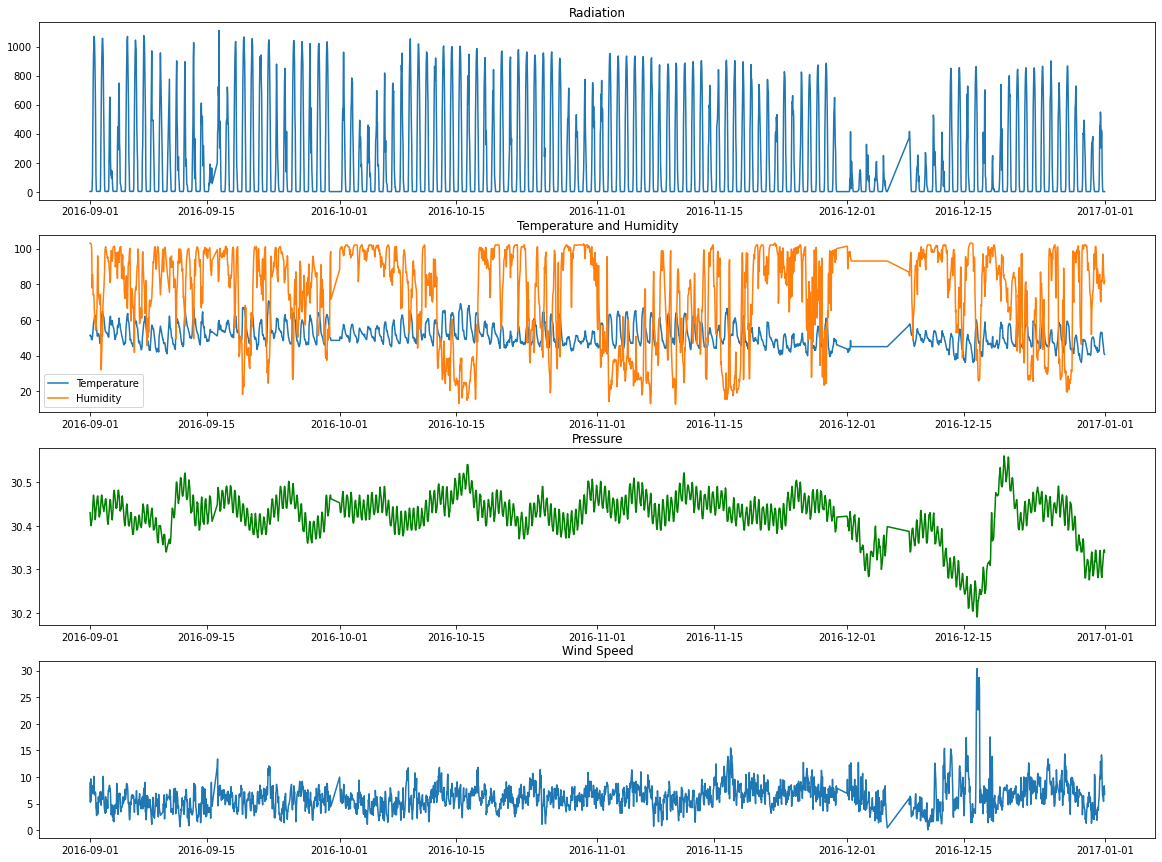

In [35]:
#Plotting Entire Series

plt.figure(figsize=(20,15))

plt.subplot(4,1,1)
plt.plot(df.Radiation,label='Radiation')
plt.title('Radiation')

plt.subplot(4,1,2)
plt.plot(df.Temperature,label='Temperature')
plt.plot(df.Humidity,label='Humidity')
plt.legend()
plt.title('Temperature and Humidity')

plt.subplot(4,1,3)
plt.plot(df.Pressure,color='green')
plt.title('Pressure')

plt.subplot(4,1,4)
plt.plot(df['Speed'])
plt.title('Wind Speed')


Text(0.5, 1.0, 'Wind Speed')

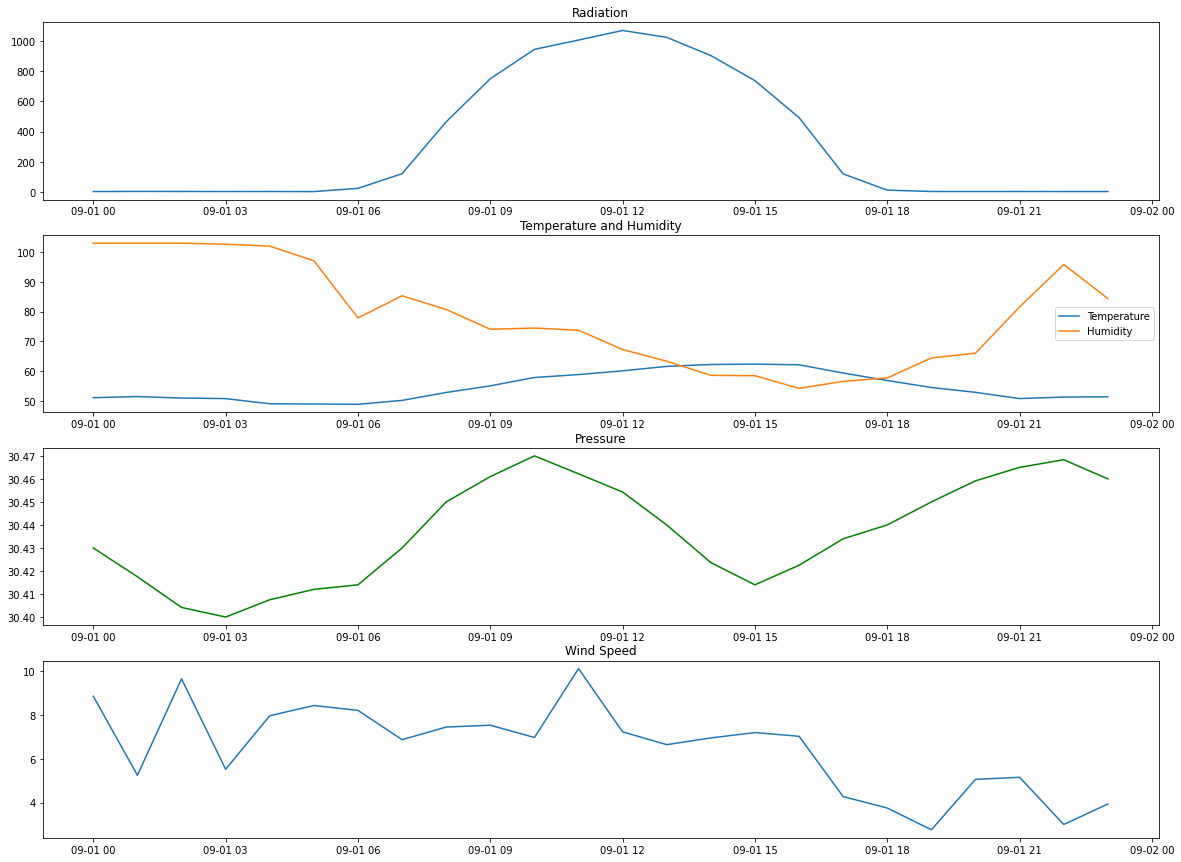

In [36]:
#Plotting a Single day's data
day = df['2016-09-01']

plt.figure(figsize=(20,15))

plt.subplot(4,1,1)
plt.plot(day.Radiation,label='Radiation')
plt.title('Radiation')

plt.subplot(4,1,2)
plt.plot(day.Temperature,label='Temperature')
plt.plot(day.Humidity,label='Humidity')
plt.legend()
plt.title('Temperature and Humidity')

plt.subplot(4,1,3)
plt.plot(day.Pressure,color='green')
plt.title('Pressure')

plt.subplot(4,1,4)
plt.plot(day['Speed'])
plt.title('Wind Speed')

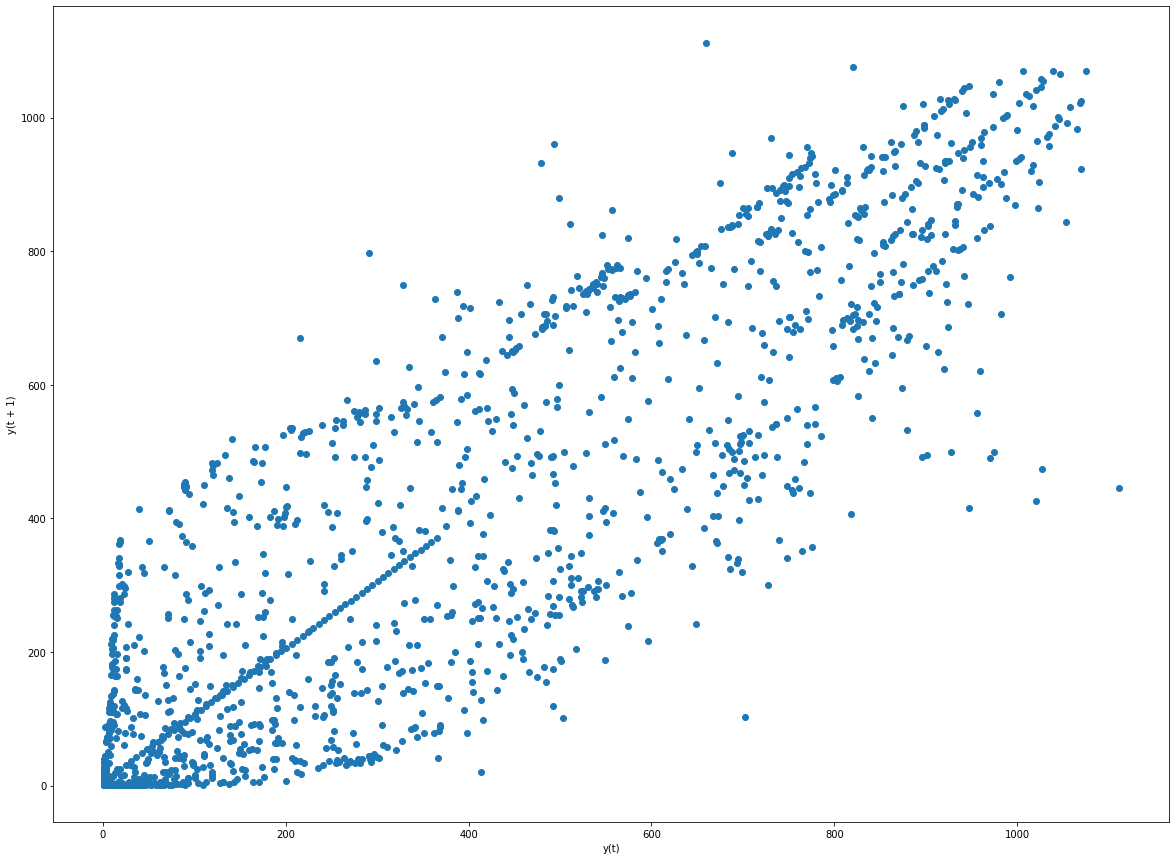

In [37]:
pd.plotting.lag_plot(df.Radiation)

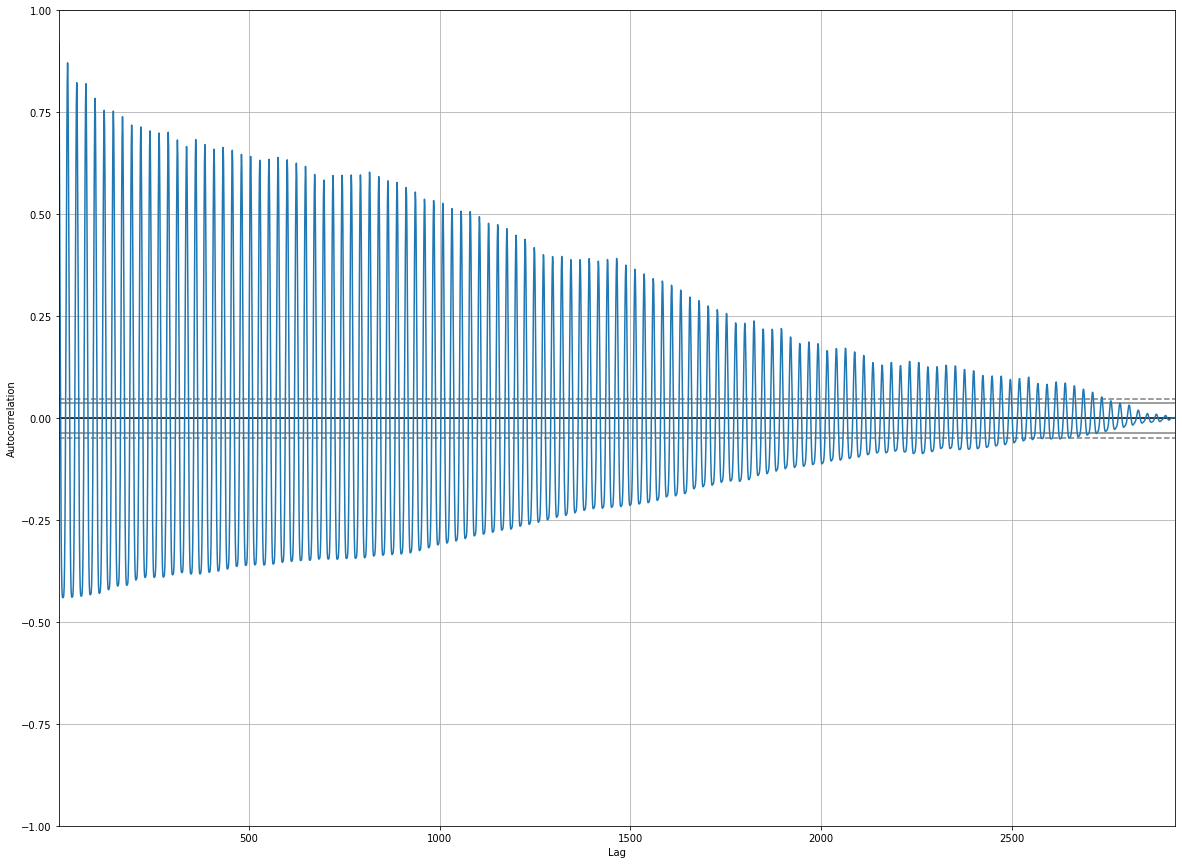

In [38]:
#from pandas.plotting import auto_correlation_plot
pd.plotting.autocorrelation_plot(df.Radiation)

The above two plot suggests that the radiation is highly correlated with it's previous time lags, therefore a rolling-window time series model may be able to accurately predict the future radiation values

### Preparing the dataset for Forecasting 
----------------

#### Splitting it to training and test data

Total Data : 122 Days
Train Data : 87 days
Test Data : 35 Days

In [39]:
split = 87 * 24

train_df = df[:split]
test_df = df[split:]

print(train_df.shape)
print(test_df.shape)

(2088, 6)
(840, 6)


### Converting the dataset to a sliding window format

In [40]:
def mmo_window(s,ws,wo):
    #ws : window size
    #wo : output step size

    X = list()
    y = list()

    for i in range(len(s)):
        #Window from i to i+ws
        end_ix = i + ws
        if end_ix > len(s) - 1:
            break
        
        end_ix_o = end_ix + wo
        if end_ix_o > len(s):
            break

        seq_x = s[i:end_ix].fillna(0)
        seq_y = s.iloc[end_ix:end_ix_o,-6].fillna(0)

        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)
    return X,y

In [41]:
X_train,y_train = mmo_window(train_df,24,24)
X_test,y_test = mmo_window(test_df,24,24)

In [42]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2041, 24, 6)
(2041, 24)
(793, 24, 6)
(793, 24)


## Evaluation Metrics
------------------------------------

- We will be predicting the data for next 24 hours, i.e. our model will output 24 steps in future
- Evaluation Metric RMSE
  - For each step in future
  - Aggregate RMSE for entire predictions





In [43]:
#For window size = w and forecast step size s
# Actual is a (n,w,)
from sklearn import metrics
import sklearn

def evaluate_forecasts(actual, predicted):
	
    #RMSE for each step of forecast
    scores = list()

    for i in range(actual.shape[1]):
        #rmse for the ith day
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(actual[:,i],predicted[:,i]))
        scores.append(rmse)
    
    #Overall RMSE
    rss = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            rss += (actual[row, col] - predicted[row, col])**2
            

    rmse = np.sqrt(rss / (actual.shape[0] * actual.shape[1]))
    

    print("----------------------------------------------------")
    print("Overall RMSE : ",rmse)
    print("RMSE per ith step ",scores)

    return rmse,scores



## ARIMA MODEL
-------------

In [44]:
!pip3 install --upgrade statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.12.1)


In [45]:
from statsmodels.tsa.arima.model import ARIMA

#ARIMA Model predicting 24 datapoints in future
def arima():

    predictions = list()

    #Fit Train data to ARIMA
    model = ARIMA(train_df.Radiation,order=(24,1,0))
    model = model.fit()

    i = 0
    l = len(train_df.Radiation)
    #For loop to predict the next 24 points for each instances of the test data point
    for t in range(len(X_test)):
    
        output = model.predict(l + i,l + 24 + i - 1)
        predictions.append([output])
        i = i + 1

    #Return the predictions
    return np.array(predictions).reshape(-1,24)

In [46]:
arima_ypred = arima()

In [47]:
arima_rmse,arima_scores = evaluate_forecasts(arima_ypred,y_test)

----------------------------------------------------
Overall RMSE :  221.03786464011165
RMSE per ith step  [220.14813216762153, 220.22110574357532, 220.29382827738326, 220.37002105207614, 220.45288203808425, 220.54558618859673, 220.65597525947095, 220.7555249471422, 220.74207889996762, 220.84424389256165, 220.88238797654284, 221.0366934139106, 221.12892447604264, 221.0941200476782, 221.11353493800033, 221.13433146969086, 221.18897367634105, 221.34901061927, 221.50300568167043, 221.65473481591636, 221.78820389418186, 221.9016831663531, 221.999967299975, 222.08684553008777]


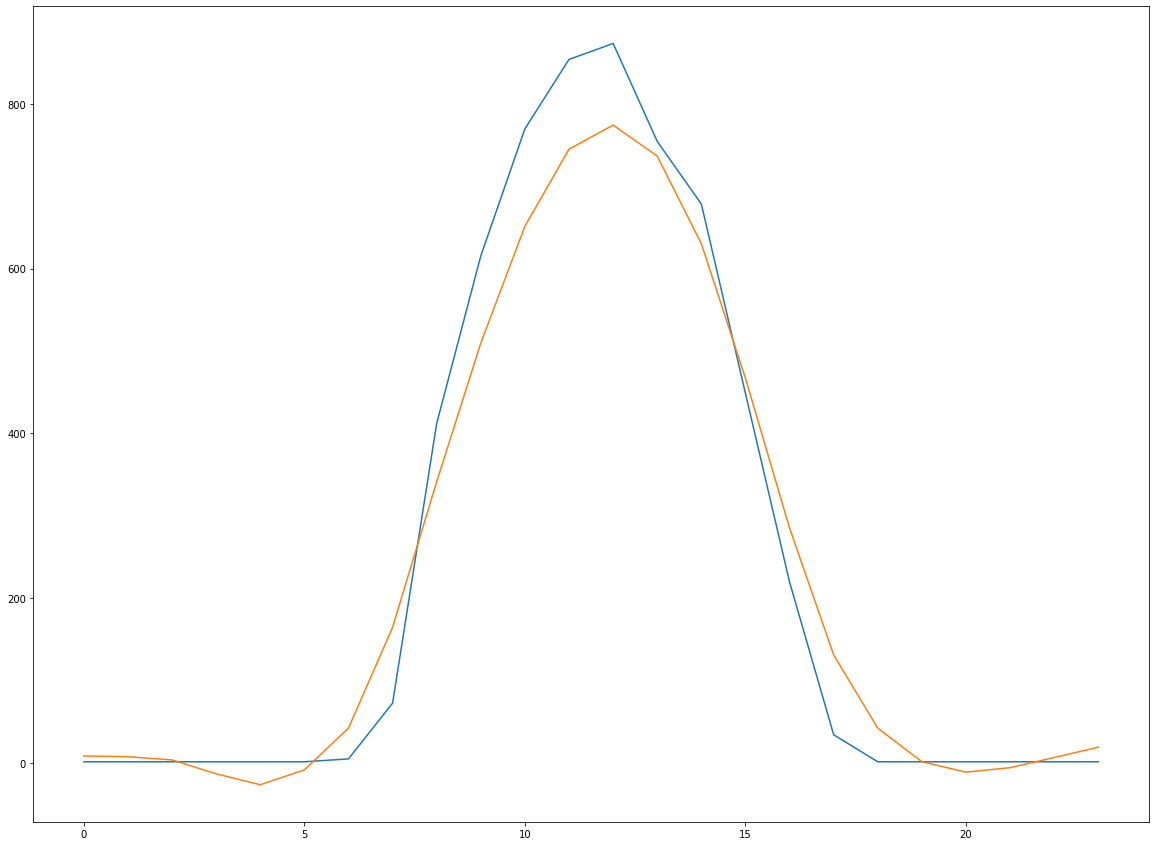

In [48]:
plt.plot(test_df['2016-11-27'].Radiation.values)
plt.plot(arima_ypred[0])

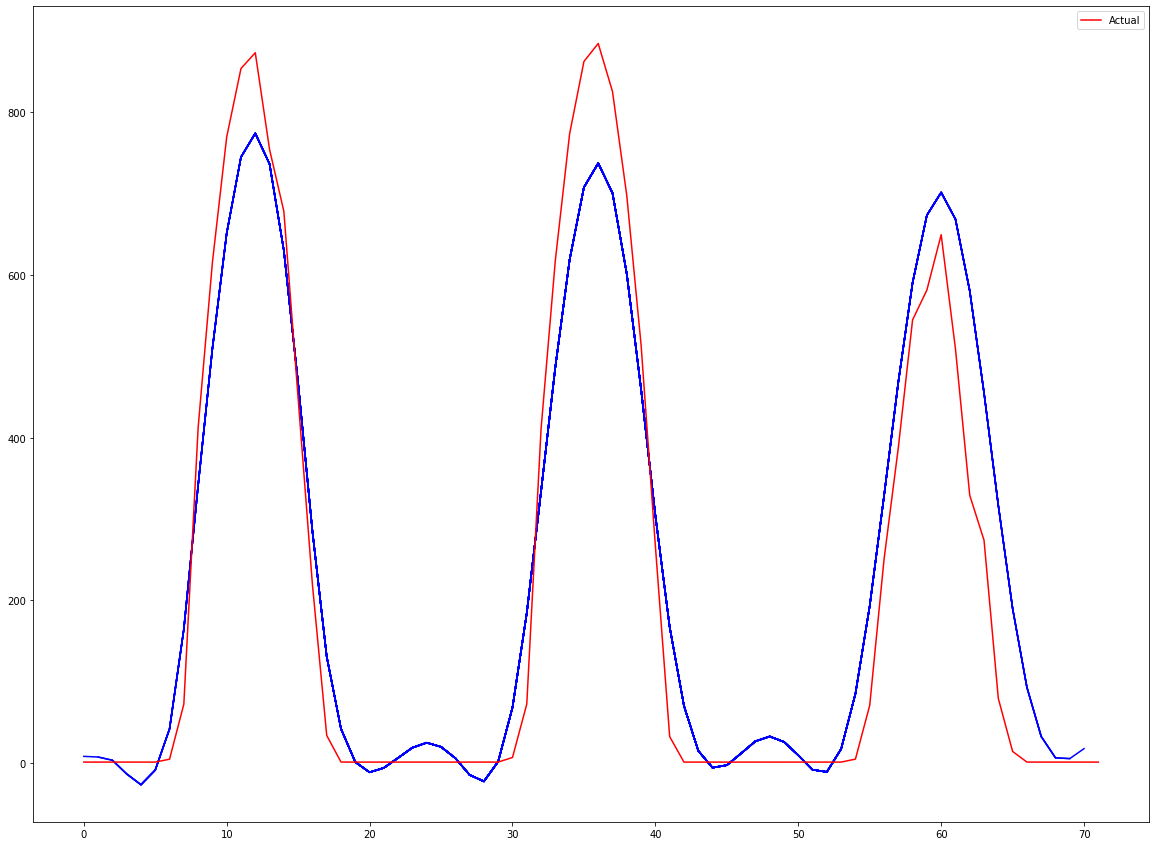

In [49]:
i = 0
for x in arima_ypred[:48]:
    plt.plot(range(i,24+i),x,color='blue')
    i = i + 1
plt.plot(test_df[:72].Radiation.values,label='Actual',color='red')
plt.legend()

## MLP MODEL
---------

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import optimizers

In [51]:
def mlp(trainX,trainy,testX,testy):
    
    inp_shape = trainX.shape[1]*trainX.shape[2]

    trainX = trainX.reshape(trainX.shape[0],inp_shape)  
    testX = testX.reshape(testX.shape[0],inp_shape)

    #Defining MLP Model
    model = Sequential()
    model.add(Dense(100,activation='relu',input_dim=inp_shape))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(trainy.shape[1]))
    model.compile(optimizer='adam',loss='mse')

    #Fitting it with train data
    model.fit(trainX.reshape(trainX.shape[0],inp_shape),trainy,epochs=100,validation_data=(testX,testy),verbose=0,callbacks=[EarlyStopping(monitor='val_loss',patience=15)])

    #Predicting and evaluating it on test accuracy
    ypred = model.predict(testX)

    rmse,scores = evaluate_forecasts(ypred,testy)

    
    plt.plot(ypred[0],label='Predicted',marker='o')
    plt.plot(test_df['2016-11-27'].Radiation.values,label='Actual')
    plt.title("1 Day prediction vs Actual Irradiance Value for the most recent day")
    plt.legend()


    return (ypred,rmse,scores)

----------------------------------------------------
Overall RMSE :  155.79757988094687
RMSE per ith step  [79.22070929740227, 94.59672377550919, 119.53855715321329, 135.0352509350852, 163.9482344361392, 171.73770288368004, 167.21503392595213, 188.86436584404572, 183.8865730447663, 176.99188374577656, 182.80175056611677, 167.17993431725583, 185.73659556452466, 158.21649176944553, 169.54425390065316, 160.66173154843452, 164.07366189703728, 162.1109011888053, 157.94989964847446, 147.31609412077188, 139.218215067347, 139.88857729239498, 134.80547427986528, 131.26303991775913]


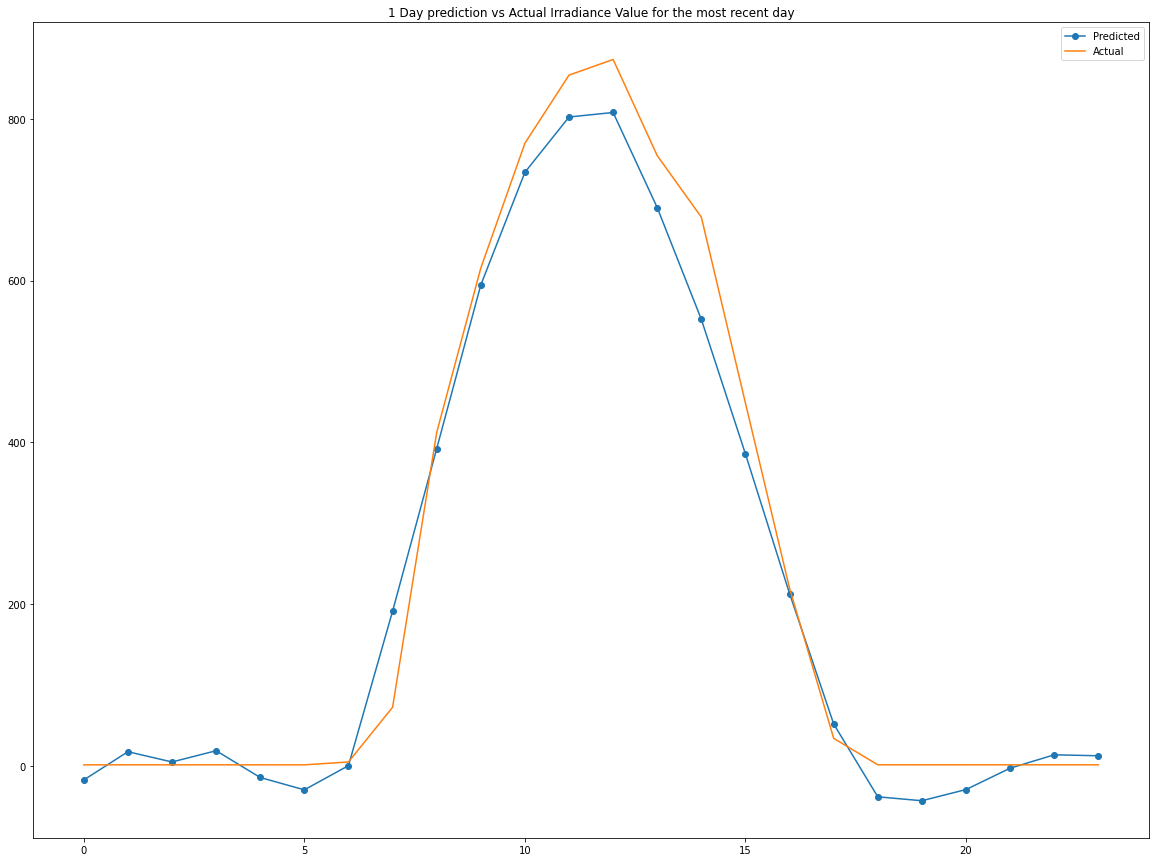

In [52]:
mlp_pred,mlp_rmse,mlp_scores = mlp(X_train,y_train,X_test,y_test)

## LSTM
-----------

In [61]:
from keras.layers import Bidirectional

def lstm(trainX,trainy,testX,testy):
    
    inp_shape = trainX.shape[1]*trainX.shape[2]

    #trainX = trainX.reshape(trainX.shape[0],inp_shape)  
    #testX = testX.reshape(testX.shape[0],inp_shape)

    model = Sequential()
    model.add(LSTM(500,input_shape=(trainX.shape[1],trainX.shape[2])))
    model.add(Dense(500))
    model.add(Dropout(0.2))
    model.add(Dense(trainy.shape[1]))
    model.compile(loss='mse',optimizer='adam')

    #Fitting it with train data
    model.fit(trainX,trainy,epochs=100,validation_data=(testX,testy),verbose=0,callbacks=[EarlyStopping(monitor='val_loss',patience=20)])

    #Predicting and evaluating it on test accuracy
    ypred = model.predict(testX)

    rmse,scores = evaluate_forecasts(ypred,testy)

    

    plt.plot(ypred[0],label='Predicted',marker='o')
    plt.plot(test_df['2016-11-27'].Radiation.values,label='Actual')
    plt.title("1 Day prediction vs Actual Irradiance Value for the most recent day")
    plt.legend()


    return (ypred,rmse,scores)

----------------------------------------------------
Overall RMSE :  161.43003269045226
RMSE per ith step  [120.20342512600695, 137.3562790876271, 151.05725302683376, 160.98435506548438, 169.68656405091906, 175.06455435427432, 174.22098424800066, 170.88183077875524, 167.12330570800663, 164.21270402208052, 160.5574736602329, 158.54977124053676, 158.6739841395553, 158.10127983677364, 156.14832779656618, 157.0537352667785, 159.49168567452264, 162.83198382272366, 167.74143915367986, 171.63511086048868, 173.12259585410104, 169.19811345498596, 162.7331335125169, 157.23757325825525]


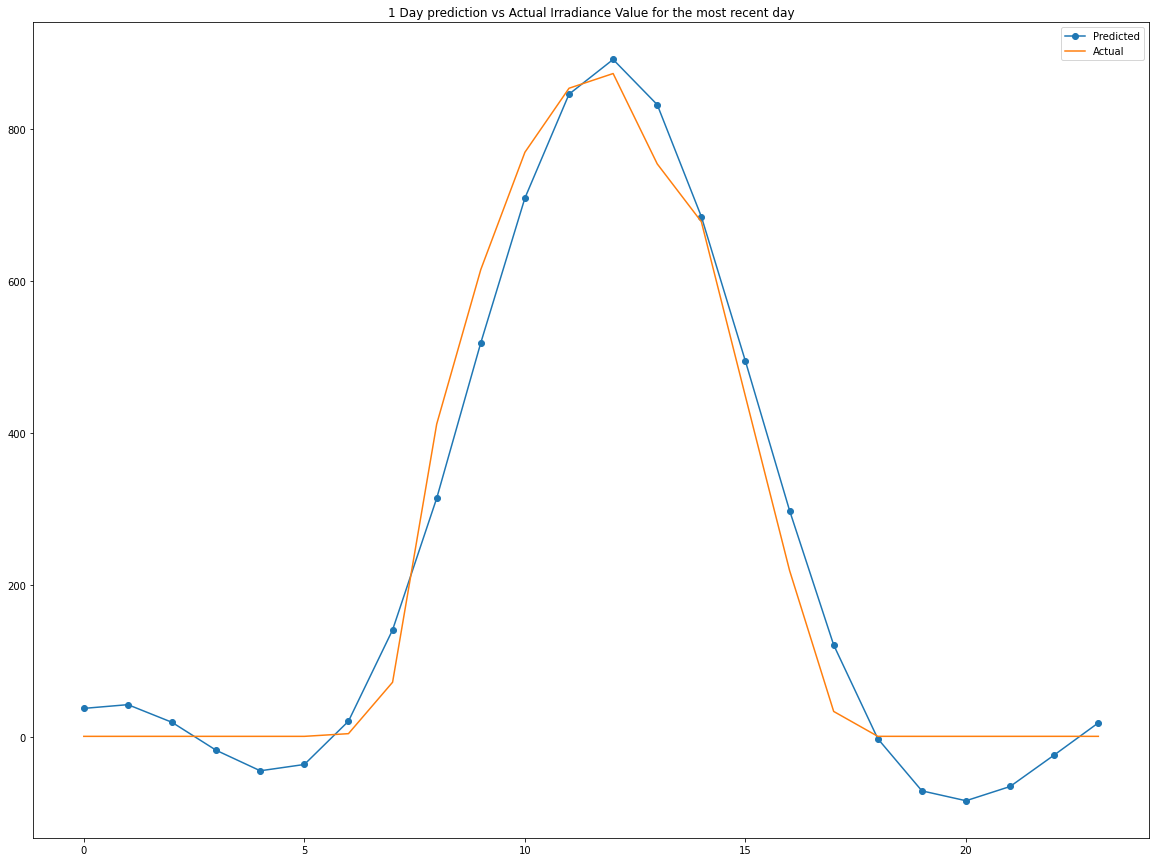

In [62]:
lstm_pred,lstm_rmse,lstm_scores = lstm(X_train,y_train,X_test,y_test)

## Evaluation of each Model
-----------

Text(0.5, 1.0, 'Step wise RMSE for each of the 1st to 24th step in future')

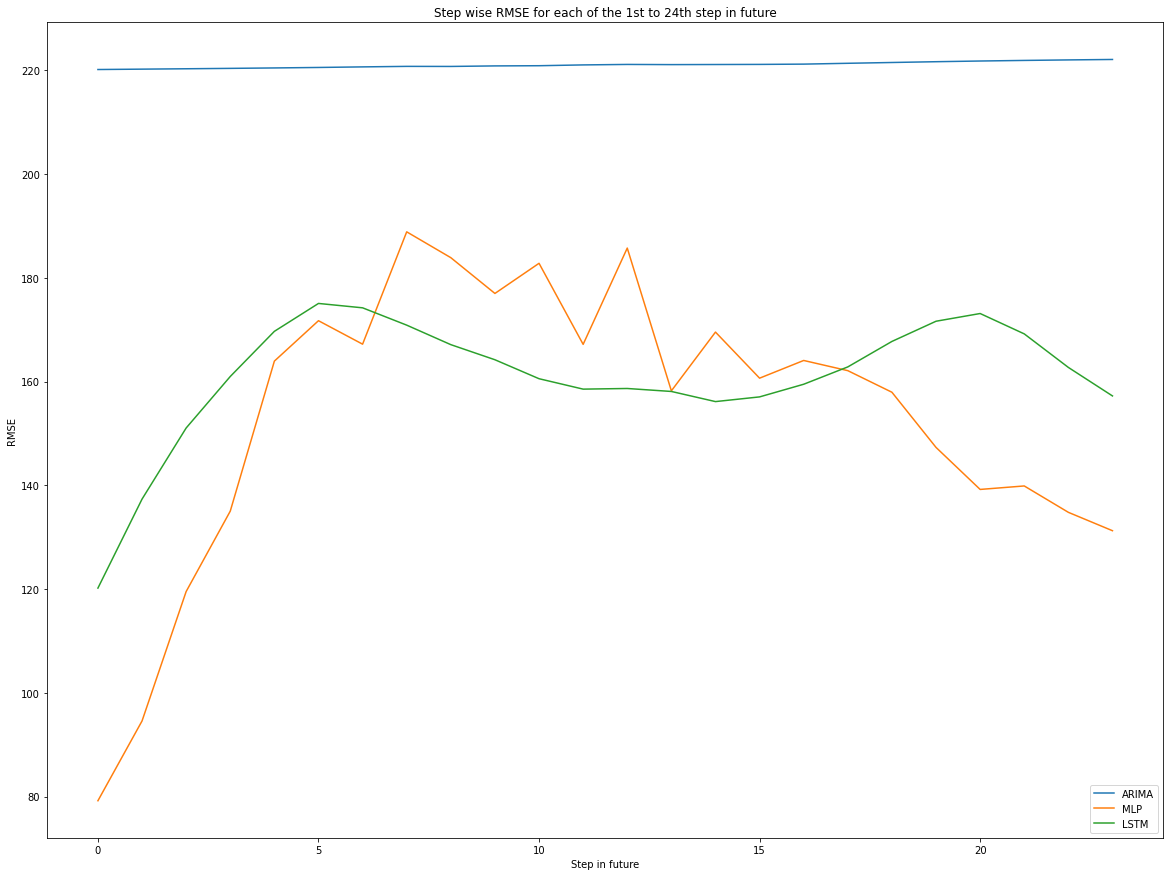

In [63]:
plt.plot(arima_scores,label='ARIMA')
plt.plot(mlp_scores,label='MLP')
plt.plot(lstm_scores,label='LSTM')
plt.legend()
plt.xlabel('Step in future')
plt.ylabel('RMSE')
plt.title('Step wise RMSE for each of the 1st to 24th step in future')

### We can see from the above graph, that that all models have low RMSE when predicting near future 

### MLP and LSTM perform significantly better, especially for multi step forecasts 

In [64]:
print("ARIMA Overall RMSE \t",arima_rmse)
print("MLP Overall RMSE \t",mlp_rmse)
print("LSTM Overall RMSE \t",lstm_rmse)

ARIMA Overall RMSE 	 221.03786464011165
MLP Overall RMSE 	 155.79757988094687
LSTM Overall RMSE 	 161.43003269045226
